# Segmentation
Segmentation describes the process of finding cells in an image. This can be done either on the nucleus or on whole cell level. Spatialproteomics provides wrappers for StarDist, mesmer and cellpose.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('../../data/BNHL_166_4_I2_LK.zarr').pp[1000:1300, 1000:1300].pp.drop_layers(keep='_image')

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
ds

<xarray.Dataset>
Dimensions:   (channels: 56, y: 301, x: 301)
Coordinates:
  * channels  (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * x         (x) int64 1000 1001 1002 1003 1004 ... 1296 1297 1298 1299 1300
  * y         (y) int64 1000 1001 1002 1003 1004 ... 1296 1297 1298 1299 1300
Data variables:
    _image    (channels, y, x) uint8 72 72 72 69 79 92 109 116 ... 3 3 2 3 3 2 3

## Nuclear Segmentation with StarDist

StarDist can perform segmentation on a single channel. Here, we show how it can be used to segment nuclei. Subsequently, we will look at how these segmentation masks can be processed in an attempt to capture the cytosol and membrane better.

In [18]:
# running the segmentation
ds_stardist = ds.tl.stardist(channel='DAPI', key_added='_stardist_segmentation')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 144/144 [02:20<00:00,  1.03it/s]


Since it is possible to have multiple segmentations in a spatialproteomics object, we need to tell the package which segmentation to treat as the default one. This is done with `pp.add_segmentation()`.

In [19]:
# adding the segmentation as default segmentation
ds_stardist = ds_stardist.pp.add_segmentation('_stardist_segmentation')

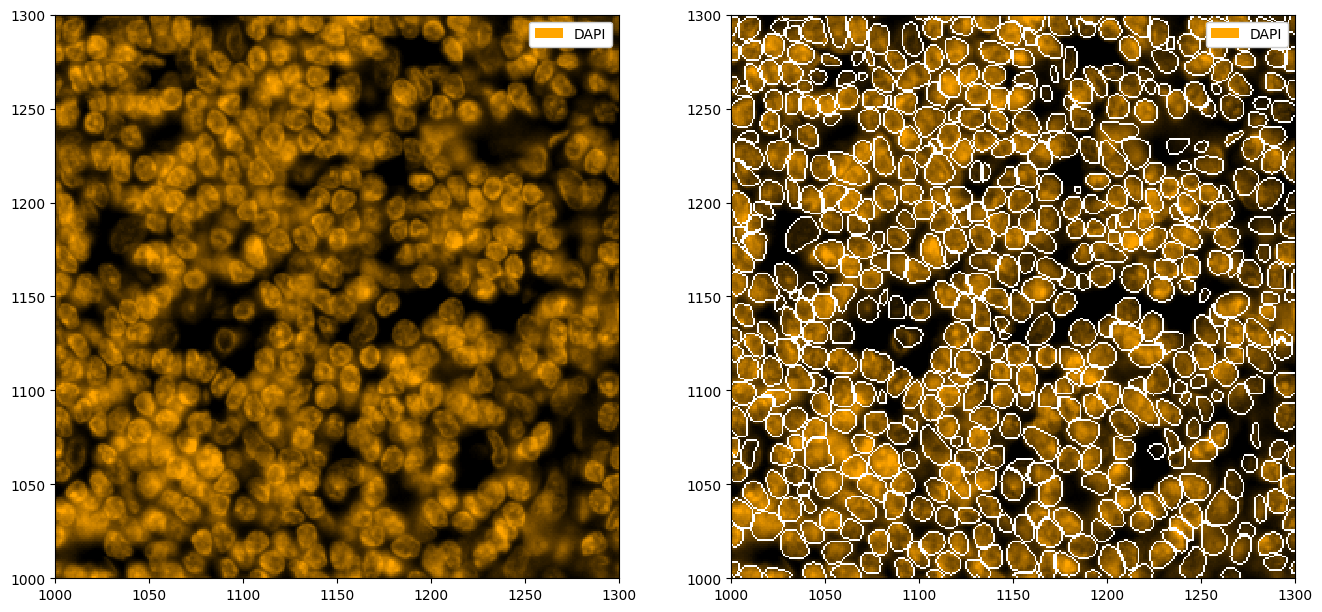

In [32]:
# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp['DAPI'].pl.colorize('orange').pl.show(ax=ax[0])
_ = ds_stardist.pp['DAPI'].pl.colorize('orange').pl.show(render_segmentation=True, ax=ax[1])

To try to capture full cells, we can grow the segmentation masks, e. g. by two pixels into each direction. If two masks collide, the masks will stop growing into that direction.

In [33]:
ds_stardist_grown = ds_stardist.pp.grow_cells(2)

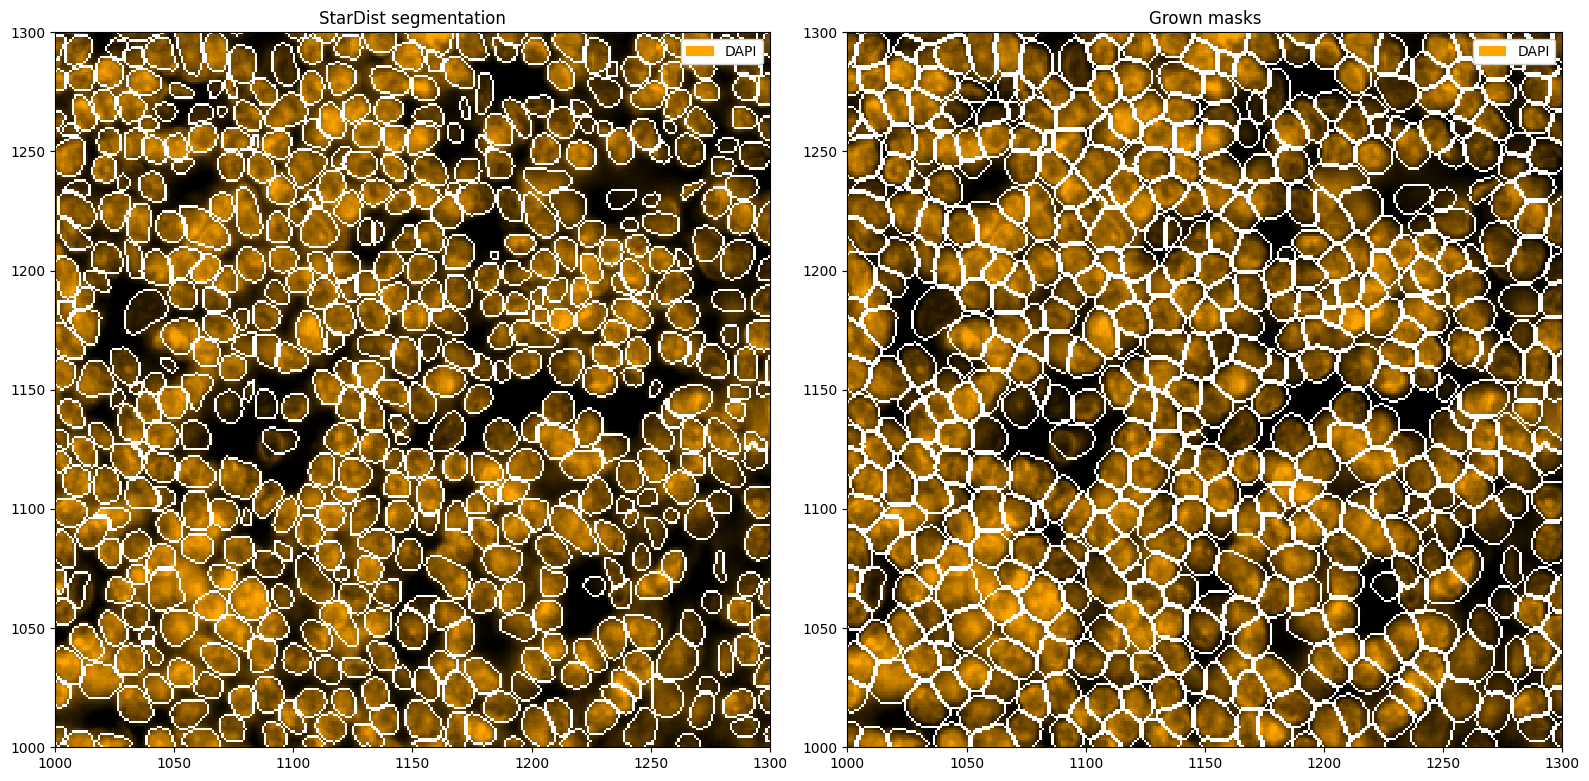

In [36]:
# plotting the segmentation
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = ds_stardist.pp['DAPI'].pl.colorize('orange').pl.show(render_segmentation=True, ax=ax[0])
_ = ds_stardist_grown.pp['DAPI'].pl.colorize('orange').pl.show(render_segmentation=True, ax=ax[1])
ax[0].set_title('StarDist segmentation')
ax[1].set_title('Grown masks')
plt.tight_layout()

## Whole Cell Segmentation with Mesmer

If you have a universal membrane marker, you can use mesmer for whole cell segmentation. Since there is no membrane marker in this dataset that is present on all cells, this is not shown here. For further information, refer to the `tl` module. The syntax is identical to that of StarDist and cellpose.

## Segmenting Multiple Channels with Cellpose

Cellpose is another state of the art tool for segmentation. Next to predicting nuclei, you can also use it to try to predict other cell types. In the following, we will see how we can use cellpose to segment three different channels independently and then merge the segmentation masks into one mask. There are some hyperparameters in cellpose which can help the prediction.

In [45]:
# segmenting on DAPI, CD11c (dendritic cells) and CD68 (macrophages)
# note that when merging the masks later, the order matters (channels take precedence by position in the subsetting)
ds_cellpose = ds.pp[['CD11c', 'CD68', 'DAPI']].tl.cellpose(key_added='_cellpose_segmentation')

TORCH CUDA version not installed/working.
>>>> using CPU
>> cyto3 << model set to be used
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 17.68 sec
>>> diameter(s) = 
[ 20.95 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 33.25 sec
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 14.22 sec
>>> diameter(s) = 
[ 21.76 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 27.12 sec
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 21.16 sec
>>> diameter(s) = 
[ 11.94 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 52.49 sec


In [46]:
ds_cellpose

<xarray.Dataset>
Dimensions:                 (channels: 3, y: 301, x: 301)
Coordinates:
  * channels                (channels) <U11 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 1000 1001 1002 1003 ... 1298 1299 1300
Data variables:
    _image                  (channels, y, x) uint8 0 0 0 0 0 ... 32 36 48 65 74
    _cellpose_segmentation  (channels, y, x) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0

In [52]:
# merging the segmentation masks into a single segmentation
# the threshold value tells you how much of a mask need to overlap for the less important one to be removed
ds_cellpose_merged = ds_cellpose.pp.merge_segmentation('_cellpose_segmentation', labels=['Dendritic Cell', 'Macrophage', 'Lymphocyte'], threshold=0.8)

In [53]:
ds_cellpose_merged

<xarray.Dataset>
Dimensions:                 (channels: 3, y: 301, x: 301)
Coordinates:
  * channels                (channels) <U11 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 1000 1001 1002 1003 ... 1298 1299 1300
Data variables:
    _image                  (channels, y, x) uint8 0 0 0 0 0 ... 32 36 48 65 74
    _cellpose_segmentation  (channels, y, x) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    _merged_segmentation    (y, x) uint16 0 0 0 0 0 0 22 22 ... 0 0 0 0 18 18 0

In [54]:
# adding the merged segmentation as the main segmentation in the object
ds_cellpose_merged = ds_cellpose_merged.pp.add_segmentation('_merged_segmentation')

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
Found _obs in image container. Concatenating.
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [55]:
ds_cellpose_merged

<xarray.Dataset>
Dimensions:                 (labels: 3, props: 2, channels: 3, x: 301, y: 301,
                             cells: 409, features: 3)
Coordinates:
  * labels                  (labels) int64 1 2 3
  * props                   (props) <U6 '_color' '_name'
  * channels                (channels) <U11 'CD11c' 'CD68' 'DAPI'
  * x                       (x) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * y                       (y) int64 1000 1001 1002 1003 ... 1298 1299 1300
  * cells                   (cells) int64 1 2 3 4 5 6 ... 405 406 407 408 409
  * features                (features) <U10 '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _properties             (labels, props) object '#CB7E98' ... 'Macrophage'
    _image                  (channels, y, x) uint8 0 0 0 0 0 ... 32 36 48 65 74
    _cellpose_segmentation  (channels, y, x) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    _merged_segmentation    (y, x) uint16 0 0 0 0 0 0 22 22 ... 0 0 0 0 18 18 0
    _obs                    (cells, features) float64 1.0 ... 1.113e+03
    _segmentation           (y, x) int64 0 0 0 0 0 0 22 22 ... 0 0 0 0 0 18 18 0

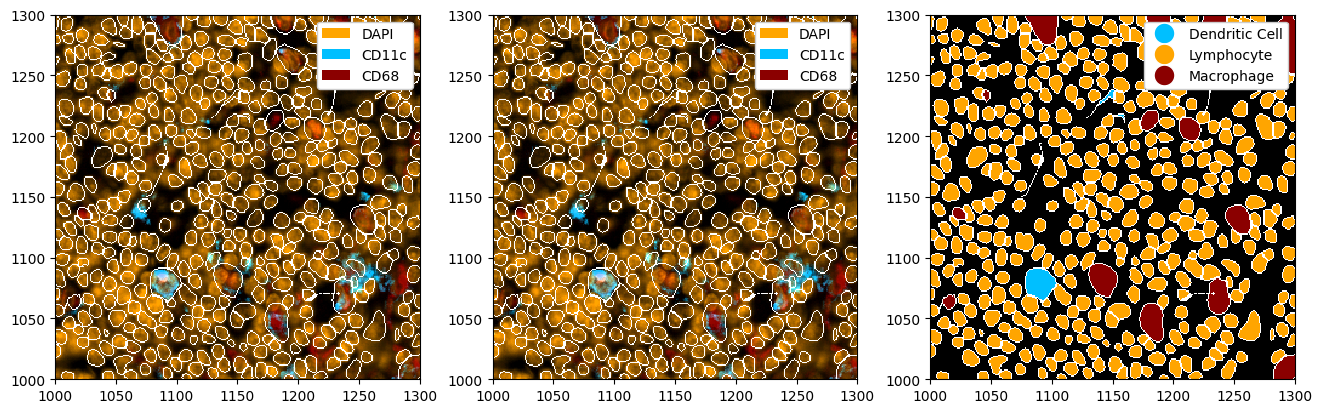

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# adding colors to match the channel colors
colors = ['orange', 'deepskyblue', 'darkred']
ds_cellpose_merged = ds_cellpose_merged.la.set_label_colors(['Lymphocyte', 'Dendritic Cell', 'Macrophage'], colors)

# original masks
_ = ds_cellpose_merged.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=colors).pl.show(render_segmentation=True, ax=ax[0])

# merged masks
_ = ds_cellpose_merged.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=colors).pl.show(render_segmentation=True, ax=ax[1])
_ = ds_cellpose_merged.pl.show(render_image=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[2])


Note that this method is far from perfect, and does not always pick up on all masks. For example, no dendritic cell was detected by cellpose. In this case, you might want to look into fine-tuning cellpose to your celltype of interest. You can also tweak the cellpose parameters to try to improve the segmentation.